<a href="https://colab.research.google.com/github/suafle/Clase2/blob/master/upper_limits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8
! sudo apt-get install msttcorefonts -qq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

In [0]:
import time
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib.colors import ListedColormap, BoundaryNorm
from astropy import units as u
from astropy.io import fits

In [0]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman'],'size':23})
rc('text', usetex=True)

In [5]:
#Loading data
file1 = '/content/drive/My Drive/PhD_data/_10-result.fits.gz'
ruwe = '/content/drive/My Drive/PhD_data/_10ruwe-result.fits.gz'

#Data and ruwe data
dat = Table.read(file1,format='fits')
dat_ruwe = Table.read(ruwe,format='fits')

#to pandas
df = dat.to_pandas()
df_ruwe = dat_ruwe.to_pandas()

df['ruwe'] = df_ruwe['ruwe']

print('All stars = ',len(df))

All stars =  268570


In [6]:
#Wiping out data with no bp - rg magnitude calculation (i.e. color)
df = df.dropna(subset=['bp_rp'])

print('All stars with bp-rp colors = ',len(df))

All stars with bp-rp colors =  266330


In [0]:
#A LOT OF CALCULATIONS
#Calculating distance
df['dist'] = 1000./df['parallax']

#Calculating absolute magnitude
df['g_abs'] = df['phot_g_mean_mag'] - 5*np.log10(df['dist']/10)

#Creating colors
df['w1_w2'] = df['w1mpro'] - df['w2mpro']
df['w2_w3'] = df['w2mpro'] - df['w3mpro']
df['w3_w4'] = df['w3mpro'] - df['w4mpro']
df['g_w4'] = df['phot_g_mean_mag'] - df['w4mpro']

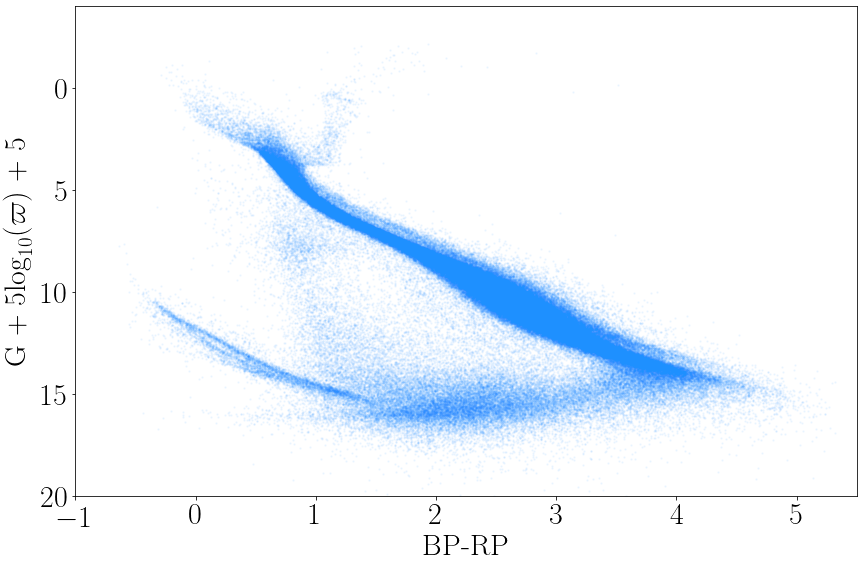

In [8]:
matplotlib.rcParams.update({'font.size': 30})

plt.figure(figsize=(14,9))
plt.scatter(df['bp_rp'],df['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.xlabel('BP-RP')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(20,-4)
plt.xlim(-1,5.5)
plt.show()
plt.close()

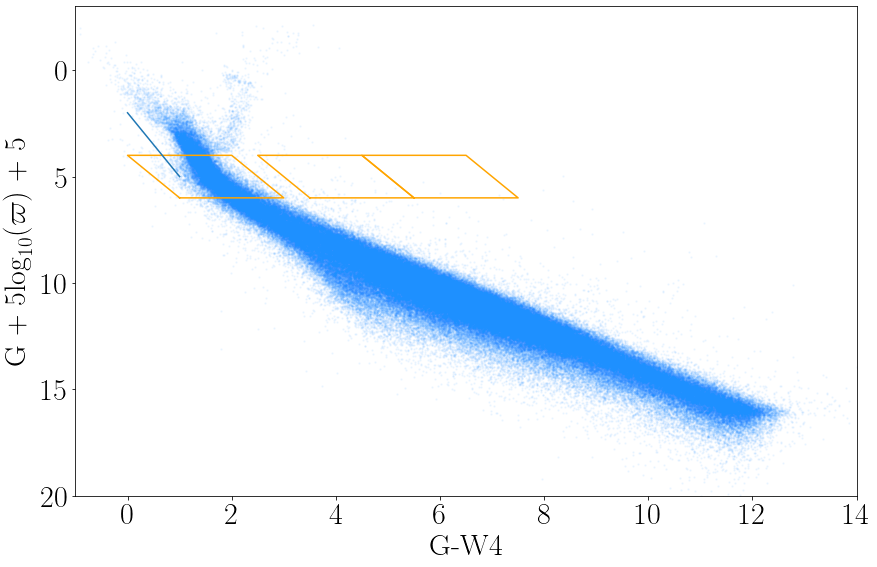

In [13]:
def linea(x,n):
  return (20/3.)*x + n

def inv_linea(m,y,n):
  return (y-n)/m

def rombo(m,y1,y2,n1,n2):
  x1 = inv_linea(m,y1,n1)
  x2 = inv_linea(m,y1,n2)
  x3 = inv_linea(m,y2,n2)
  x4 = inv_linea(m,y2,n1)
  x5 = x1
  return [x1,x2,x3,x4,x5],[y1,y1,y2,y2,y1]

def rombod(y1,y2,x1,x4,dx): #y1 top line (smallest), y2 bottom line (largest), x1 upper-left corner, x4 bottom-left corner
  m = (y1-y2)/(x1-x4)
  n1 = y1 - m*x1
  n2 = y2 - m*(x1 + dx)
  x2 = (y1 - n2)/m
  x3 = (y2 - n2)/m
  return [x1,x2,x3,x4,x1],[y1,y1,y2,y2,y1]

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))

#plt.scatter(df['bp_rp_real'],df['g_abs'],alpha=0.05,c='dodgerblue')
plt.scatter(df['g_w4'],df['g_abs'],alpha=0.05,c='dodgerblue',s=2)

rombo_a = rombod(6,4,1,0,1)
rombo_b = rombod(6,4,3.5,2.5,1)
rombo_c = rombod(6,4,5.5,4.5,1)

plt.plot(rombo_a[0],rombo_a[1],c='orange')
plt.plot(rombo_b[0],rombo_b[1],c='orange')
plt.plot(rombo_c[0],rombo_c[1],c='orange')

x = np.array([2,5])
plt.plot(np.array([2,5]),)

plt.xlabel('G-W4')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.xlim(-1,14)
plt.ylim(20,-3)
plt.show()
plt.close()